In [222]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

import glob
import os
import re

import ast

plt.style.use("default")
params = {
    'ytick.color': "black",
    'xtick.color': "black",
    'axes.labelcolor': "black",
    'axes.edgecolor': "black",
    'axes.linewidth': 1,
    'text.usetex': True,
    'font.family': "serif",
    'font.weight': "bold",
    'font.serif': ["Computer Modern Serif"],
    'font.size': 24,
}

plt.rcParams.update(params)
plt.rcParams['font.size'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

In [223]:
# read CSV files and combine into a single dataframe
path = r'analysed_results'
csv_files = glob.glob(os.path.join(path , "*.csv"))
print(csv_files)

temp_list = []
for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    temp_list.append(df)

combined_data = pd.concat(temp_list, axis=0, ignore_index=True)

['analysed_results/25.6.2023-scaling-queue.csv', 'analysed_results/25.6.2023-baseline-queue.csv', 'analysed_results/27.6.2023-baseline.csv', 'analysed_results/26.6.2023-scaling-10-results.csv', 'analysed_results/30.1.2023-scaling-results_old.csv', 'analysed_results/1.2.2023-scalability-extension.csv', 'analysed_results/31.1.2023-baseline.csv', 'analysed_results/26.6.2023-hybrid.csv', 'analysed_results/31.1.2023-mobility.csv', 'analysed_results/1.2.2023-scalability-extension_old.csv', 'analysed_results/25.6.2023-hybrid.csv', 'analysed_results/31.01.2023-realcloud.csv', 'analysed_results/25.6.2023-baseline-queue-2.csv', 'analysed_results/30.1.2023-scaling-results.csv']


In [224]:
graphs = {
    'graph1': {
        'name': 'scale-10',
        'data': ['scatterpp-scaling-10'],
        'permutation_order': [0, 1, 2],
        'plots': {
            'plot1': {
                'legends': {
                    'exp': [0, -0.5, 1, 1.7],
                    'services': [0, 0.95, 3, 0.2]
                },
                'legend_size': 16,
                'legend_cols': 2,
                'figsize': [30, 7],
                'height_ratios': [1, 1, 1, 1],
                'subplots': (1, 6),
                'graphs': {
                    'graph0': {
                        'name': "FPS",
                        'results_key': 'fps',
                        'graph_index': 0,
                        'subplot_loc': (0,0),
                        'filler': False,
                        'y_axis_lims': [0,31],
                        'y_tick_marks': [0,31,10]
                    },
                    "graph1": {
                        "name": r"\begin{center}Service Lat. (ms)\end{center}",
                        "results_key": "services",
                        "graph_index": 1,
                        "subplot_loc": (0, 1),
                        "filler": False,
                        "y_axis_lims": [0, 75],
                        "y_tick_marks": [0, 61, 20],
                    },
                    "graph2": {
                        "name": r"\begin{center}Mem. (GB)\end{center}",
                        "results_key": "memory",
                        "graph_index": 2,
                        "subplot_loc": (0, 2),
                        "filler": False,
                        "y_axis_lims": [0, 30],
                        "y_tick_marks": [0, 29, 7],
                    },
                    "graph3": {
                        "name": r"\begin{center}GPU Util. (\%)\end{center}",
                        "results_key": "gpu_util",
                        "graph_index": 3,
                        "subplot_loc": (0, 3),
                        "filler": False,
                        "y_axis_lims": [0, 60],
                        "y_tick_marks": [0, 61, 15],
                    },
                    "graph4": {
                        "name": r"\begin{center}CPU Util. (\%)\end{center}",
                        "results_key": "cpu",
                        "graph_index": 4,
                        "subplot_loc": (0, 4),
                        "filler": False,
                        "y_axis_lims": [0, 11],
                        "y_tick_marks": [0, 11, 2],
                    },
                    "graph5": {
                        "name": r"\begin{center}Success (\%)\end{center}",
                        "results_key": "success_rate",
                        "graph_index": 5,
                        "subplot_loc": (0, 5),
                        "filler": False,
                        "y_axis_lims": [0, 105],
                        "y_tick_marks": [0, 101, 25],
                    },
                }
            }
        }
    },
}

In [225]:
# variables for graph plotting

colours = [
    '3a77b2', 'f3812d', '459e32', 'ca2e33', '9169bb', '86574d', 'da7ac2',
    'babc34', '4ebdcd'
]

server_dict = {
    'gpu02': {
        'label': 'Edge2 (E2)',
        'shorthand': '(E2)'
    }, 
    'cm-01-05-061': {
        'label': 'Edge1 (E1)',
    },
    'ip-172-31-28-206': {
        'label': 'Cloud (C)'
    },
    'E1': {
        'hatch': 'xxx',
        'cores': 10,
        'cuda_cores': 4352
    },
    'E2': {
        'hatch': '..',
        'cores': 32,
        'cuda_cores': 10752
    },
    'C': {
        'hatch': '..',
        'cores': 18,
        'cuda_cores': 5120
    }
}

service_dict = {
    'primary': {
        'colour': '#ef476f',
        'loc': 0
    },
    'sift': {
        'colour': '#ffd166',
        'loc': 1
    },
    'encoding': {
        'colour': '#06d6a0',
        'loc': 2
    },
    'lsh': {
        'colour': '#7bbee9',
        'loc': 3
    },
    'matching': {
        'colour': '#576aa8',
        'loc': 4
    },
}

bar_width = 0.2

In [226]:
# graph analysis functions

def client_bar_locs(dataframe):
    curr_locs = {}
    locs_list = []
    count_bars = 0
    for i in dataframe:
        curr_loc = i
        if i == 0:
            count_bars += 1
        try:
            latest_loc = curr_locs[i]
        except:
            curr_locs[i] = i + 1 - bar_width
            latest_loc = curr_locs[i]
        
        new_loc = np.around(latest_loc + bar_width, 1)
        curr_locs[i] = new_loc
        locs_list.append(new_loc)
            
    num_bars = len(curr_locs)
    locs_list = np.array(locs_list) - (count_bars/2)*bar_width + bar_width/2 #(num_bars*bar_width + bar_width)/2
    return locs_list

def graph_labels(graph_name, experiment_name, curr_deploy_setup):
    curr_deploy_setup = ast.literal_eval(curr_deploy_setup)
    # generating labels based on experiment name
    if graph_name == 'loss':
        label_data_packet_loss = curr_deploy_setup['packet_loss']
        
        if 'e-' in str(label_data_packet_loss):
            label_data_packet_loss =  f'{label_data_packet_loss:.5f}'
        
        label = f'Packet Loss: {label_data_packet_loss}\%' 
    elif graph_name == 'latency':
        label_data_latency = np.array(curr_deploy_setup['latencies'])
        client_primary_latency = label_data_latency[2]
        
        label = f'Latency: {client_primary_latency} ms'         
    elif 'scale' in graph_name:
        label_data = curr_deploy_setup['permutation']
        replicas = curr_deploy_setup['replicas']
        label = str(replicas)
    else:
        # for if the servers are different
        label_data = curr_deploy_setup['permutation']
        if label_data.count(label_data[0]) == len(label_data): # check if the same element throughout
            first_item = label_data[0]
            label = server_dict[first_item]['label']
        else:
            label = "["
            concurrent_server = ""
            for k in range(len(label_data)):
                perm_name = label_data[k]
                if 'concurrent' in experiment_name and k == len(label_data)-1:
                    # ignore final service on concurrent workload
                    concurrent_server = server_dict[perm_name]['label'][-3:-1]
                    continue 
                label_item = server_dict[perm_name]['label'][-3:-1]
                if 'C' in label_item:
                    label_item = server_dict[perm_name]['label'][-2:-1]
                label += f'{label_item},'
            label += "]"
            label = ''.join(label.rsplit(',', 1)) # removing final comma
            if 'concurrent' in experiment_name:
                label = f'{concurrent_server}: {label}'
        if experiment_name == "2.1.2023-scale":
            replicas = curr_deploy_setup['replicas']
            label = label + " " + str(replicas)
    return label

def permutation_analysis(graph_name, df_exp, df_perm):
    labels = []
    for i in range(len(df_exp)):
        curr_exp = df_exp.iloc[i]
        curr_perm = df_perm.iloc[i]
        
        # generating legend labels
        legend_label = graph_labels(graph_name, curr_exp, curr_perm)
        labels.append(legend_label)
        
    # generating the colours
    labels_unique = np.unique(labels)
    lu_num = len(labels_unique)
    selected_colours = colours[:lu_num]
    
    colours_dict = {labels_unique[i]: selected_colours[i] for i in range(len(labels_unique))}    
    colours_list = [f'#{colours_dict[i]}' for i in labels]
    
    return labels, colours_list

def column_types(df_input):
    columns_data_types = df_input.dtypes
    unique_data_types = columns_data_types.unique()
    
    columns = {}
    for dtype in unique_data_types:
        columns[dtype.name] = (columns_data_types[columns_data_types==dtype].keys()).values
    return columns
        
def results_analyser(df_results, df_storage):
    unique_experiments = df_results['experiment'].unique()    
    for experiment in unique_experiments:
        experiment_results = df_results[df_results['experiment'] == experiment]
        unique_permutations = experiment_results['permutation'].unique()
        
        columns = column_types(experiment_results) # columns that have numeric data
        columns_numeric = columns['float64']
        columns_int = columns['int64']
        columns_obj = columns['object']
        
        columns_avg = [x for x in columns_numeric if 'avg' in x]
        columns_std = [x for x in columns_numeric if 'std' in x]
        for permutation in unique_permutations:
            permutation_results = experiment_results[experiment_results['permutation'] == permutation]
            client_nums = permutation_results['client'].unique()
            for client in client_nums:
                curr_client_results = permutation_results[permutation_results['client'] == client].fillna(0)
                curr_client_med = curr_client_results[columns_numeric].median().to_frame().T                
                curr_client_obj = curr_client_results[columns_obj]
                curr_client_int = curr_client_results[columns_int]
                cc_obj_int = curr_client_results.groupby(['experiment','permutation', 'client'], as_index=False)[['deployment_latencies', 'deployment_clients']].agg(list)
                                
                curr_client_res = pd.concat([cc_obj_int, curr_client_med], axis=1)     
                
                # recalculating the standard deviation
                curr_client_res[columns_std] = curr_client_results[columns_avg].std()

                df_storage = pd.concat([df_storage, curr_client_res], axis=0, ignore_index=True)
    return df_storage

def cpu_normaliser(permutation, service, results):    
    permutation_list = np.array(permutation)
    
    results_list = np.array(results)
    results_normalised = np.array([])

    service_loc = service_dict[service]['loc']
    
    for i in range(len(permutation_list)):
        curr_perm = permutation_list[i]
        curr_result = results_list[i]
        
        # if deployed entirely on one server
        if '[' not in curr_perm:
            server_type = curr_perm[curr_perm.find("(")+1:curr_perm.find(")")]
            if 'L' in curr_perm:
                cores = server_dict['E1']['cores']
            elif 'Packet Loss' in curr_perm:
                cores = server_dict['E1']['cores']
            else:
                cores = server_dict[server_type]['cores']
        elif '[' in curr_perm:
            if ':' in curr_perm:
                curr_perm = curr_perm.split(':')[1]
            curr_perm_stripped = curr_perm.replace('[', '').replace(']', '').split(',')
            curr_server = curr_perm_stripped[service_loc].strip()
            cores = server_dict['E2']['cores']
        norm_result = curr_result / cores
        results_normalised = np.append(results_normalised, norm_result)
    return results_normalised

def gpu_normaliser(permutation, service, results):
    permutation_list = np.array(permutation)
    
    results_list = np.array(results)
    results_normalised = np.array([])

    service_loc = service_dict[service]['loc']
    
    for i in range(len(permutation_list)):
        curr_perm = permutation_list[i]
        curr_result = results_list[i]
        
#         # if deployed entirely on one server
#         if '[' not in curr_perm:
#             server_type = curr_perm[curr_perm.find("(")+1:curr_perm.find(")")]
#             if 'L' in curr_perm:
#                 cores = server_dict['E1']['cuda_cores']
#             elif 'Packet Loss' in curr_perm:
#                 cores = server_dict['E1']['cuda_cores']
#             else:
#                 cores = server_dict[server_type]['cuda_cores']
#         elif '[' in curr_perm:
#             if ':' in curr_perm:
#                 curr_perm = curr_perm.split(':')[1]
#             curr_perm_stripped = curr_perm.replace('[', '').replace(']', '').split(',')
#             curr_server = curr_perm_stripped[service_loc].strip()
#             cores = server_dict[curr_server]['cuda_cores']
        norm_result = curr_result / 4 #/ cores
        results_normalised = np.append(results_normalised, norm_result)
    return results_normalised

def x_posn_changer(graph_name, x, x_decimals, correct_order):   
    x = np.around(x, 1)
    
    x_as_index = int(x)
    x_as_decimal = np.around(np.modf(x)[0], 2)
#     print(x_decimals, correct_order, x, x_as_index, x_as_decimal)  

    x_decimal_posn = np.where(x_decimals == x_as_decimal)[0][0]
    print(x_decimals, correct_order, x, x_as_index, x_as_decimal, x_decimal_posn)
    correct_order_posn = correct_order[x_decimal_posn]
    
    x_decimal = x_decimals[correct_order_posn]
    new_x = float(x_as_index + x_decimal)
    
    # for loss graphs:
    if graph_name == 'loss':
        if x_decimal == 0.05:
            new_x += 1 
        elif x_decimal == 0.85:
            new_x -= 1
    elif graph_name == 'cloud':
        if x_decimal == 0.95:
            new_x -= 1
        elif x_decimal == 0.05:
            new_x += 1
    elif 'concurrent' in graph_name:
        if x_decimal == 0.95:
            new_x -= 1
        elif x_decimal == 0.25:
            new_x += 1

    #print(x_decimals, correct_order, x, x_as_index, x_as_decimal, x_decimal_posn, correct_order_posn, x_decimal, new_x)
    return new_x
    
def x_posns_rearranger(graph_name, input_x, input_y, correct_order):  
#     print(input_x)

    current_order = input_y['permutation'].unique().tolist()
    ordered_list = [current_order[i] for i in correct_order]
        
    x_decimals = np.around(np.modf(input_x)[0], 2).unique()
    new_x_posns = input_x.apply(lambda x: x_posn_changer(graph_name, x, x_decimals, correct_order))
    print(new_x_posns)
    return new_x_posns        

def concurrent_clients(permutations):
    concurrent_programs = []
    for curr_perm in permutations:
        curr_deploy_setup = ast.literal_eval(curr_perm)
        curr_replicas = curr_deploy_setup['replicas']
        
        curr_programs = curr_replicas[-1] - 1
        concurrent_programs.append(curr_programs)
    return concurrent_programs

Current graph is scale-10 and uses ['26.6.2023-scaling-10-results']
{'permutation': ['gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061'], 'replicas': [1, 2, 2, 1, 2], 'scaling': 10, 'latencies': [0, 0, 1, 0, 0, 0], 'packet_loss': 1e-05}
{'permutation': ['gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061'], 'replicas': [1, 2, 2, 1, 2], 'scaling': 10, 'latencies': [0, 0, 1, 0, 0, 0], 'packet_loss': 1e-05}
{'permutation': ['gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061'], 'replicas': [1, 2, 2, 1, 2], 'scaling': 10, 'latencies': [0, 0, 1, 0, 0, 0], 'packet_loss': 1e-05}
{'permutation': ['gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061', 'gpu02:cm-01-05-061'], 'replicas': [1, 2, 2, 1, 2], 'scaling': 10, 'latencies': [0, 0, 1, 0, 0, 0], 'packet_loss': 1e-05}
{'permutation': ['gpu02:

/tmp/ipykernel_2326/854704581.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_combined['legend_labels'] = legend_labels
/tmp/ipykernel_2326/854704581.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_combined['bar_colours'] = bar_colours
/tmp/ipykernel_2326/854704581.py:115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

encoding
0     19.099712
1     23.940563
2     24.760008
3     25.645137
4     25.575042
5     26.320457
6     26.744843
7     25.460005
8     25.460005
9     24.960041
10    19.479752
11    24.489880
12    24.379730
13    24.859905
14    27.480125
15    26.719570
16    27.699947
17    25.959969
18    27.770042
19    24.779558
20    18.879890
21    25.340080
22    25.979996
23    28.220177
24    27.940273
25    27.760506
26    24.729967
27    26.719570
28    23.479939
29    22.999763
Name: services_matching_avg, dtype: float64
0      9.549856
1     11.970282
2     12.380004
3     12.822568
4     12.787521
5     13.160229
6     13.372421
7     12.730002
8     12.730002
9     12.480021
10     9.739876
11    12.244940
12    12.189865
13    12.429953
14    13.740063
15    13.359785
16    13.849974
17    12.979984
18    13.885021
19    12.389779
20     9.439945
21    12.670040
22    12.989998
23    14.110088
24    13.970137
25    13.880253
26    12.364984
27    13.359785
28    11.739969
29 

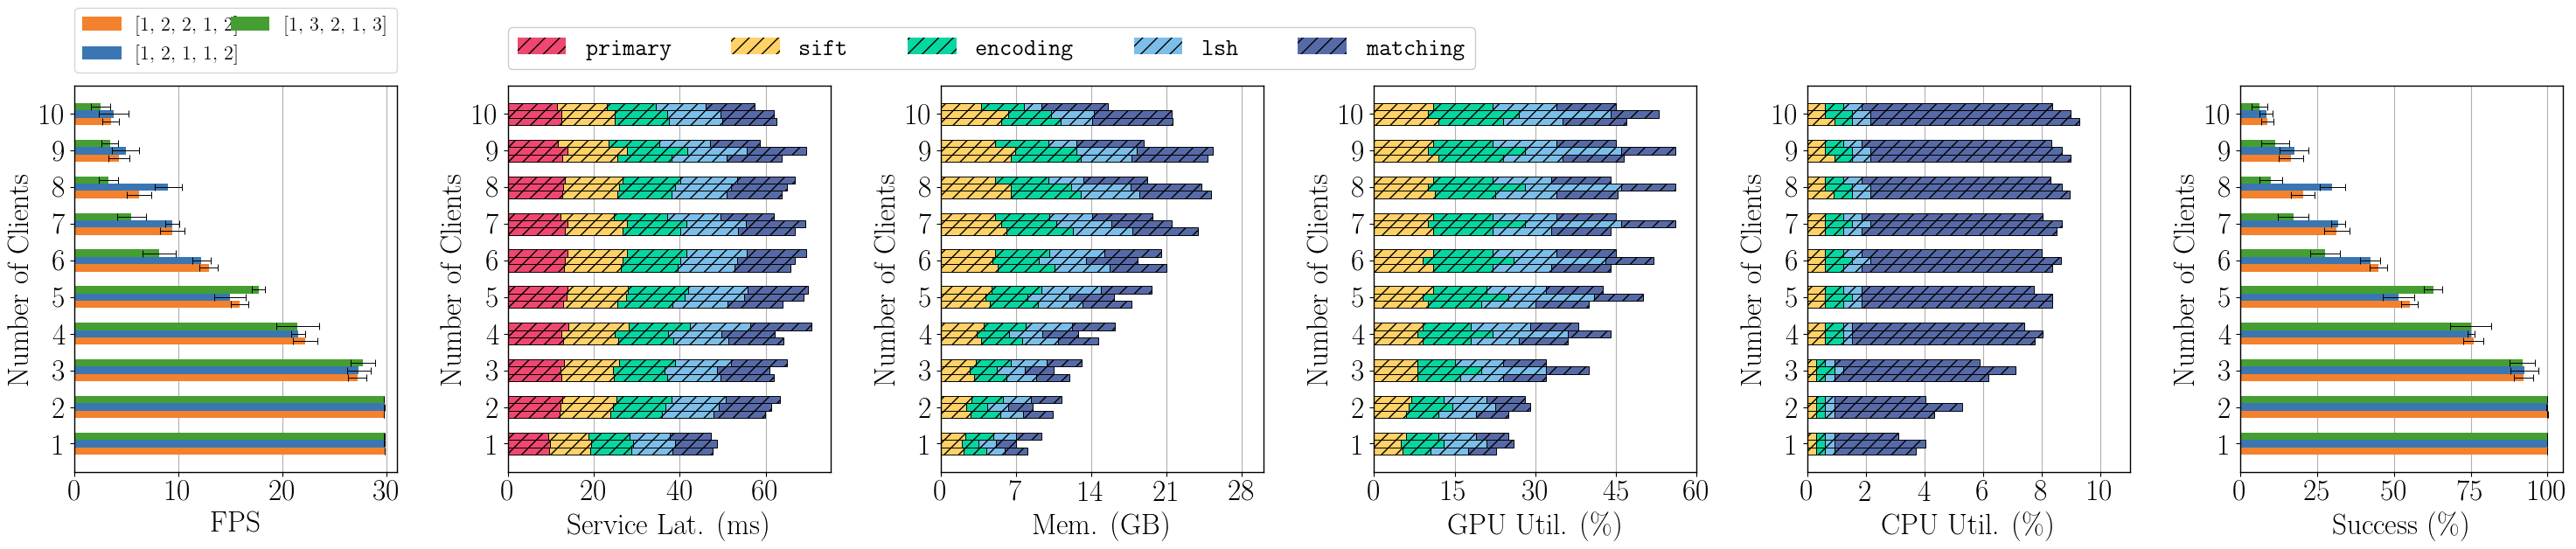

In [227]:
for graph_name in graphs:
#     print(graph_name)
    bar_width = 0.2
    relevant_data_files = graphs[graph_name]['data']
    curr_graph_name = graphs[graph_name]["name"]
    print(f'Current graph is {curr_graph_name} and uses {relevant_data_files}')
    data_mask = combined_data['experiment'].apply(lambda x: any(item for item in relevant_data_files if item in x))
    relevant_results = combined_data[data_mask]
                
    # remove rows that are 4 or more clients
#     relevant_results = relevant_results.drop(relevant_results[relevant_results.client > 3].index)

    # calculate median of results across the permutations
    df_combined = pd.DataFrame() 
    df_combined = results_analyser(relevant_results, df_combined)
#     print(df_combined)
        
    if curr_graph_name in ['loss', 'latency']:
        # select out the correct/relevant permutations 
        rel_results = pd.DataFrame()
        loss_latency_permutations = df_combined['permutation'].unique()
        for perm in loss_latency_permutations:
            curr_deploy_setup = ast.literal_eval(perm)

            label_data_latency = np.array(curr_deploy_setup['latencies'])
            client_service_latency = label_data_latency[1]
            client_primary_latency = label_data_latency[2]
            label_data_packet_loss = curr_deploy_setup['packet_loss']
            
            # select data that has current permutation
            rel_lines = df_combined[df_combined['permutation'] == perm]
            
            if curr_graph_name == 'loss':
                if label_data_packet_loss > 0 and client_primary_latency == 1:
                    rel_results = pd.concat([rel_results, rel_lines])
                if client_primary_latency == 1 and label_data_packet_loss == 0:
                    rel_results = pd.concat([rel_results, rel_lines])
            elif curr_graph_name == 'latency':
                if label_data_packet_loss == 1e-05:
                    rel_results = pd.concat([rel_results, rel_lines])
            
        df_combined = rel_results 
#     elif curr_graph_name == 'scale':
#         rel_results = pd.DataFrame()
#         scale_permutations = df_combined['permutation'].unique()
        
#         to_keep = [[1, 2, 2, 1, 2], [1, 2, 1, 1, 2], [2, 2, 1, 1, 1]]
#         for perm in scale_permutations:
#             curr_deploy_setup = ast.literal_eval(perm)
            
#             curr_replica = curr_deploy_setup['replicas']

#             if curr_replica in to_keep:
#                 rel_lines = df_combined[df_combined['permutation'] == perm]
#                 rel_results = pd.concat([rel_results, rel_lines])
#         df_combined = rel_results 
#     elif 'edge' in curr_graph_name:
#         print(df_combined['experiment'].unique())
    elif curr_graph_name == 'concurrent_gpu':
#         rel_results = pd.DataFrame()
#         concurr_permutations = df_combined['permutation']
#         concurr_experiments = df_combined['experiment']
        
#         to_remove = [['gpu02', 'gpu02', 'gpu02', 'gpu02', 'gpu02', 'gpu02'], 
#                      ['gpu02', 'gpu02', 'cm-01-05-061', 'cm-01-05-061', 'cm-01-05-061', 'gpu02']]
#         bad_experiment = '1.2.2023-concurrent-gpu'
        
#         for i in range(len(concurr_permutations)):
#             perm = concurr_permutations[i]
#             exp = concurr_experiments[i]
                                     
#             curr_deploy_setup = ast.literal_eval(perm)
#             curr_perm = curr_deploy_setup['permutation']
            
#             if curr_perm in to_remove and exp == bad_experiment:
#                 print(exp)
#                 continue
#             else:
#                 rel_lines = df_combined[df_combined['permutation'] == perm]
#                 rel_results = pd.concat([rel_results, rel_lines])
#         df_combined = rel_results 
        df_combined = df_combined.drop([0,2])
        df_combined = df_combined.reindex([1, 4, 3, 5])
    
#         print(df_combined)
                
    
#     print(df_combined['permutation'].unique())
        
    # analyse permutations to create legends and assign bar colours 
    experiments = df_combined['experiment']
    permutations = df_combined['permutation']
    for i in range(len(permutations)):
        curr_perm = permutations.iloc[i]
        print(curr_perm)
#     print("ahh", permutations)
        
    perm_analysis = permutation_analysis(curr_graph_name, experiments, permutations)
            
    legend_labels = perm_analysis[0]
    df_combined['legend_labels'] = legend_labels
    
    bar_colours = perm_analysis[1]
    df_combined['bar_colours'] = bar_colours

    # find how many clients, i.e., locations of the groups of bars
    clients_no = len(df_combined['client'].unique())    
    
    # prepare x-axis data for plotting, i.e., bar locations
    clients = df_combined['client']
#     if 'concurrent_cpu' in curr_graph_name:
#         clients = concurrent_clients(permutations)
#         clients_no = len(np.unique(clients))
    bar_locs = client_bar_locs(clients)
    df_combined['bar_locs'] = bar_locs
    
    print(f'There are {len(permutations.unique())} permutations and {clients_no} clients')
    
    cg_rel_x_posns = df_combined['bar_locs']
    cg_rel_permutation = df_combined['permutation']
    
    # rearrange data in specified permutation order
    correct_order = graphs[graph_name]['permutation_order']
#     cg_x_posns = x_posns_rearranger(curr_graph_name, cg_rel_x_posns, df_combined, correct_order)
    cg_x_posns = cg_rel_x_posns
    
#     if 'concurrent_gpu' in graph_name:
#         cg_x_posns 
        
    plots = graphs[graph_name]['plots']
    
    # e2e calculation
    e2e = df_combined['e2e_avg']
    services_val = 0 
    for service in service_dict:
        curr_ser_res = df_combined[f'services_{service}_avg']
        services_val += curr_ser_res
#     print(e2e)
#     print(services_val)
    diff = e2e-services_val
#     print(diff, np.median(diff), np.std(diff))

    for plot_key, plot_item in plots.items():
        graphs_to_be_made = plot_item['graphs']        
#         num_plots = len(graphs_to_be_made)
        subplots = plot_item['subplots']
        figsize = plot_item['figsize']
        height_ratios = plot_item['height_ratios']
        legends = plot_item['legends']
        
        try:
            legend_size = plot_item['legend_size']
        except:
            legend_size = 9
            
        try:
            legend_cols = plot_item['legend_cols']
        except:
            legend_cols = 3
        
        try:
            gridspec_config = plot_item['gridspec']
        except:
            gridspec_config = {'hspace':0}
        
        fig, axs = plt.subplots(subplots[0], subplots[1],
                                figsize=figsize, gridspec_kw=gridspec_config)
    
        for j in range(len(graphs_to_be_made)):
            curr_graph = graphs_to_be_made[f'graph{j}']
            subplot_loc = curr_graph['subplot_loc']
            
            subplot_loc = subplot_loc[1]
            
            if curr_graph['filler']:
                continue
            cg_key = curr_graph['results_key'] # curr_graph_key

            graph_index = curr_graph['graph_index']
            
            cg_y_label = curr_graph['name']
            axs[subplot_loc].set_xlabel(r'{{{}}}'.format(cg_y_label))
            
            if cg_key in ['fps', 'success_rate', 'e2e', 'jitter']:
                cg_rel_results = df_combined[f'{cg_key}_avg']
                cg_rel_err = df_combined[f'{cg_key}_std']
                
                cg_rel_labels = df_combined['legend_labels']
                cg_rel_colours = df_combined['bar_colours']
                
                axs[subplot_loc].barh(cg_x_posns, cg_rel_results, xerr=cg_rel_err, 
                        label=cg_rel_labels, color=cg_rel_colours, height=bar_width,
                        capsize=3, zorder=2, linewidth=0.7,
                                     error_kw={'linewidth':0.7, 'capthick':0.7})
            elif cg_key in ['cpu', 'memory', 'services']:
                prev_ser_res = 0
                for service in service_dict:
                    if cg_key == 'cpu':
                        curr_ser_res = df_combined[f'gpu_{service}_cpu_percent_avg']
                        curr_ser_res = cpu_normaliser(df_combined['legend_labels'], service, curr_ser_res)
                    elif cg_key == 'memory':
                        curr_ser_res = df_combined[f'gpu_{service}_memory.used_avg'] / 1000
                        
                    if cg_key == 'services':
                        print(service)
                        print(prev_ser_res)
                        print(curr_ser_res)
                        print(cg_x_posns)

                    axs[subplot_loc].barh(cg_x_posns, curr_ser_res, 
                                         left=prev_ser_res, height=bar_width,
                                         color=service_dict[service]['colour'],
                                         label=r'$\texttt{{{}}}$'.format(service),
                                         edgecolor='black', zorder=2, linewidth=0.7,
                                         hatch='//')
                    prev_ser_res += curr_ser_res
#                 else:
#                     prev_ser_res = 0
#                     for service in service_dict:
#                         curr_ser_res = df_combined[f'{cg_key}_{service}_avg']
#                         if cg_key == 'cpu' and curr_graph_name != "scale":
#                             curr_ser_res = cpu_normaliser(df_combined['legend_labels'], service, curr_ser_res)
#     #                     if cg_key == 'services':
#     #                         print(curr_ser_res)

#                         axs[subplot_loc].barh(cg_x_posns, curr_ser_res, 
#                                              left=prev_ser_res, height=bar_width,
#                                              color=service_dict[service]['colour'],
#                                              label=r'$\texttt{{{}}}$'.format(service),
#                                              edgecolor='black', zorder=2, linewidth=0.7,
#                                              hatch='//')
#                         prev_ser_res += curr_ser_res
            elif 'gpu' in cg_key:
                prev_ser_res = 0
                for service in service_dict:
                    if 'memory' in cg_key:
                        curr_ser_res = df_combined[f'gpu_{service}_gpu_memory_usage_avg'] / 1000
#                         print(curr_ser_res)
                    elif 'util' in cg_key:
                        try:
                            curr_ser_res = df_combined[f'gpu_{service}_utilization.gpu_avg']
                        except:
                            pass
                    axs[subplot_loc].barh(cg_x_posns, curr_ser_res, 
                                         left=prev_ser_res, height=bar_width,
                                         color=service_dict[service]['colour'],
                                         label=r'$\texttt{{{}}}$'.format(service),
                                         edgecolor='black', zorder=2, linewidth=0.7, 
                                         hatch='//')
                    prev_ser_res += curr_ser_res

            axs[subplot_loc].xaxis.grid('major', zorder=0)
            axs[subplot_loc].tick_params(axis='both')
            
            y_axis_lims = curr_graph['y_axis_lims']
            axs[subplot_loc].set_xlim(y_axis_lims)
            
            yat = curr_graph['y_tick_marks']
            y_axis_ticks = np.arange(yat[0], yat[1], yat[2])
            axs[subplot_loc].set_xticks(y_axis_ticks)
            print(subplot_loc, y_axis_lims, yat, y_axis_ticks)

        
            x_vals = np.arange(0, clients_no, 1) + 1
            axs[subplot_loc].set_yticks(x_vals)    
            axs[subplot_loc].set_ylabel(r'{Number of Clients}')
#         if 'concurrent' in curr_graph_name:
# #                 axs[col_loc,k].set_xlabel(r'\textbf{Num. Concurr. Apps.}', size=10)
#             axs.set_xlabel('', size=10)
#             axs.xaxis.set_major_locator(ticker.NullLocator())

# #                 axs[col_loc,k].set_xlabel(r'\begin{center}Num. of\\Concurrent Apps.\end{center}', size=10)

        services_legend_list = []
        for legend_key, legend_item in service_dict.items():
            service_name = legend_key
            service_colour = legend_item['colour']

            services_legend_list.append(mpatches.Patch(facecolor=service_colour, hatch='//',
                label=r'$\texttt{{{}}}$'.format(service_name)))

        try:
            service_legend = axs[1].legend(
                handles=services_legend_list, prop={'size': 20}, 
                bbox_to_anchor=legends['services'], loc='upper left', 
                    borderaxespad=0, ncol=5, framealpha=1, mode='expand')
        except:
            service_legend = axs[1].legend(
                handles=services_legend_list, prop={'size': 20}, 
                bbox_to_anchor=legends['services'], loc='upper left', 
                    borderaxespad=0, ncol=5, framealpha=1, mode='expand')


        correct_order = [0, 1, 2]
        handles, labels = axs[0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))

        try:
            exp_legend = axs[0,0].legend(
                [list(by_label.values())[idx] for idx in correct_order], 
                [list(by_label.keys())[idx] for idx in correct_order], 
                prop={'size': legend_size}, bbox_to_anchor=legends['exp'], 
                loc='upper left', borderaxespad=0, ncol=legend_cols, mode='expand')
        except:
            exp_legend = axs[0].legend(
                [list(by_label.values())[idx] for idx in correct_order], 
                [list(by_label.keys())[idx] for idx in correct_order], 
                prop={'size': legend_size}, bbox_to_anchor=legends['exp'], 
                loc='upper left', borderaxespad=0, ncol=legend_cols, mode='expand')
            
#         plt.gca().invert_yaxis()

        fig.align_ylabels(axs)
        plt.tight_layout()
        plt.savefig(f'graphs_conext/{curr_graph_name}_{plot_key}.pdf', bbox_inches='tight', pad_inches=0.01)
        plt.show()
    #print(relevant_results)